In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 3 May 2023
# Description:
#     this script compares methods of calculate the OHC and surface heat flux integrated over the continental shelf
#     - update to xarray open_mfdataset from open_dataset brought new functions more efficient to calculate model layer thickness (dz)
# and ocean heat content tendencies (rho0*Cp*dT/dt). 

In [2]:
# read nc output from WAOM 10km run

import xarray as xr
# import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [3]:
fig_path = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/'

In [4]:
%%time

# using xr.open_mfdataset

vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]

ds = xr.open_mfdataset(paths="/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_diag/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"

#- preserving 5-days avgs
temp = ds.variables["temp"] 
salt = ds.variables["salt"]
shflux = ds.variables["shflux"] 
ssflux = ds.variables["ssflux"]
m = ds.variables["m"]
# HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
# HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
Hvom = ds.variables["Hvom"] 
Huon = ds.variables["Huon"] 

ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
print("Vtransform=2")
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice

ds.close()


Vtransform=2
CPU times: user 7.81 s, sys: 5.36 s, total: 13.2 s
Wall time: 13.2 s


In [5]:
%%time

ds = xr.open_mfdataset(paths="/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_diag/ocean_his_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, decode_times=False) #, chuncks="auto", concat_dim="ocean_time"

#- preserving 5-days avgs
temp_snap = ds.variables["temp"] 

ds.close()


CPU times: user 4.55 s, sys: 2.64 s, total: 7.19 s
Wall time: 6.65 s


In [6]:
%%time

# calculate dT/dt by differentiating temp_snap:
temp_Rate = np.empty(temp_snap.shape)
dT = np.empty(temp_snap.shape)

# needs the initial conditions:
ds = xr.open_dataset('/g/data3/hh5/tmp/access-om/fbd581//ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr9/ocean_rst.nc')
temp_ini = ds.variables["temp"].isel(ocean_time=-1, two=0) # 5-days mean
ds.close()

    
tlen = len(temp[:,0,0,0])

CPU times: user 44.4 ms, sys: 16.7 ms, total: 61.1 ms
Wall time: 78.6 ms


In [7]:
%%time

# transform to DataArray
temp_snap = xr.DataArray(temp_snap)
temp_ini = xr.DataArray(temp_ini)

# - append temp_ini to first time index in temp_snap and then do diff
temp_snap = xr.concat([temp_ini,temp_snap], 'ocean_time')
dT = temp_snap.diff('ocean_time')
print(dT.shape)

# 
dt = 5*86400 # 5-days in seconds
temp_Rate = np.divide(dT, dt)
temp_Rate = xr.DataArray(temp_Rate)
# temp_Rate=temp_Rate.rename({'dim_0':'ocean_time','dim_1':'s_rho','dim_2':'eta_rho','dim_3':'xi_rho'})

print(dT.shape)

temp_Rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')

print(temp_Rate.shape)

(31, 1400, 1575, 73)
(31, 1400, 1575, 73)
(73, 31, 1400, 1575)
CPU times: user 413 ms, sys: 625 ms, total: 1.04 s
Wall time: 1.04 s


In [8]:
# load ROMS avg output
for mm  in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    ds = xr.open_dataset('/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_diag/ocean_avg_00' + mm + '.nc')
    print(ds.variables["temp"].shape)
    shflux_tmp = ds.variables["shflux"] # X,560,630

    # concatanate monthly avgs into a yearly variable
    if mm == '01':
        shflux2 = shflux_tmp
    else:
        shflux2 = np.concatenate((shflux2,shflux_tmp), axis=0)
    ds.close()


(7, 31, 1400, 1575)
(6, 31, 1400, 1575)
(6, 31, 1400, 1575)
(6, 31, 1400, 1575)
(6, 31, 1400, 1575)
(6, 31, 1400, 1575)
(6, 31, 1400, 1575)
(6, 31, 1400, 1575)
(6, 31, 1400, 1575)
(6, 31, 1400, 1575)
(6, 31, 1400, 1575)
(6, 31, 1400, 1575)


In [9]:
# calculate surface sigma_theta (potential density)
sigma_t_sfc = gsw.rho(salt[:,-1,:,:],temp[:,-1,:,:],0) - 1000

# load ice draft to create masks
di = xr.open_dataset('/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_diag/ocean_avg_0001.nc')
ice_draft = di.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
di.close()

dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom4_frc/waom4extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]

ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset

area=np.divide(1,pm*pn)

In [10]:
%%time
# method 2 to calculate Dz:
# z_w=z_w.chunks(chunks={'eta_rho': '200MB'}) # couldn't change chunks.

Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
print(z_w.shape, Z_w.shape)
dz = np.diff(Z_w,axis=1)


(73, 1400, 1575, 32) (73, 32, 1400, 1575)
CPU times: user 1min 50s, sys: 38min 54s, total: 40min 44s
Wall time: 4min 23s


In [11]:
# this mask needs to be replaced by mask_shelf2 that uses the 1500-m contour

mask_shelf = ma.masked_where(h > 1500, np.ones(h.shape))

In [12]:
# determine constants:
rho0 = 1025 # kg. m-3
Cp = 3989.245 # J.kg-1.degC-1
Tf = -1.95 # degC

In [13]:
%%time

# use -1000 mask to compute integral of surface heat fluxes and ocean heat content tendency:
# temp_Rate=xr.DataArray(temp_Rate)
temp_rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')
dT = dT.transpose('ocean_time','s_rho','eta_rho','xi_rho')

## Integrated heat tendency and sfc heat flux terms to check heat budget closure:

# 1. area-integral surface heat flux
tlen = len(temp_rate[:,0,0,0])
area_sum =  np.nansum(np.nansum(area,axis=1), axis=0)

shflux_int = np.empty((tlen))
for mm in np.arange(0,tlen):
    ###shflux_area = shflux[mm,:]*area*mask_shelf*mask_coast
    # needs xarray masking:
    shflux_area = shflux[mm,:].where(h < 1500)*area
    shflux_int[mm] = np.nansum(np.nansum(shflux_area,axis=1), axis=0)
    # del shflux_area
    
# 2. volume-integral heat tendency
temp_rate_int = np.empty((tlen))
temp_rate_vol = np.empty(np.squeeze(temp_Rate[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_rate_dz = temp_Rate[mm,:].where(h < 1500)*dz[mm,:]
    temp_rate_vint = np.nansum(temp_rate_dz, axis=0)
    temp_rate_vol[mm,:] = temp_rate_vint*area*mask_shelf#*mask_coast
    del temp_rate_vint
    temp_rate_int[mm] = np.nansum(np.nansum(temp_rate_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 9min 59s, sys: 6min 19s, total: 16min 18s
Wall time: 6min 5s


In [14]:
%%time

# 3. surface heat flux
shflux2_int = np.empty((tlen))
for mm in np.arange(0,tlen):
    shflux2_area = shflux2[mm,:]*area*mask_shelf#*mask_coast
    shflux2_int[mm] = np.nansum(np.nansum(shflux2_area,axis=1), axis=0)
    del shflux2_area

# 4. volume-integral heat tendency using old temp_Rate2:
# temp_rate2_int = np.empty((tlen))
# temp_rate2_vol = np.empty(np.squeeze(temp_Rate2[:,0,:,:]).shape)
# for mm in np.arange(0,tlen):
# # - multplying by dz:
#     temp_rate2_dz = temp_Rate2[mm,:]*dz[mm,:]
#     temp_rate2_vint = np.nansum(temp_rate2_dz, axis=0)
#     temp_rate2_vol[mm,:] = temp_rate2_vint*area*mask_shelf
#     del temp_rate2_vint
#     temp_rate2_int[mm] = np.nansum(np.nansum(temp_rate2_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 2.25 s, sys: 0 ns, total: 2.25 s
Wall time: 2.27 s


Text(0, 0.5, 'W.m$^{-2}$')

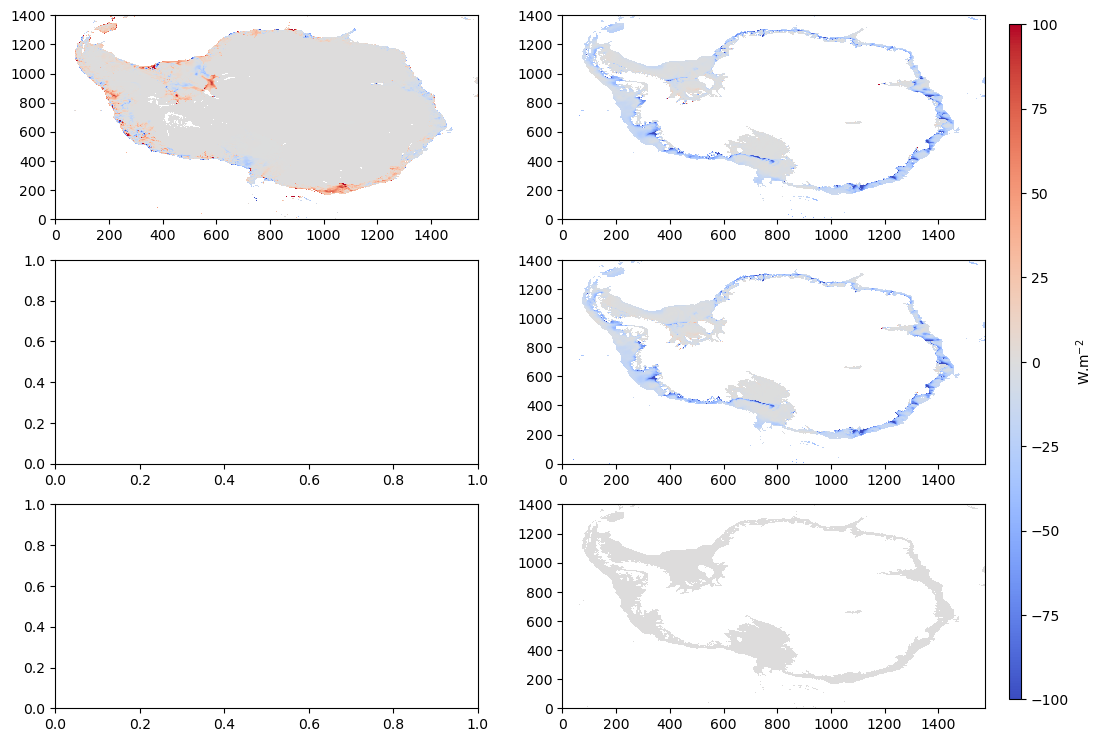

In [15]:
    
fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (12,9))

aa=ax[0,0].pcolormesh(np.nanmean(temp_rate_vol, axis=0)*mask_shelf, vmin=-100, vmax=100, cmap='coolwarm')
# plt.colorbar(aa)

bb=ax[0,1].pcolormesh(np.nanmean(shflux, axis=0)*mask_shelf, vmin=-100, vmax=100, cmap='coolwarm')


dd=ax[1,1].pcolormesh(np.nanmean(shflux2, axis=0)*mask_shelf, vmin=-100, vmax=100, cmap='coolwarm')

# diff maps:
ff=ax[2,1].pcolormesh((np.nanmean(shflux, axis=0)*mask_shelf)-(np.nanmean(shflux2, axis=0)*mask_shelf), vmin=-100, vmax=100, cmap='coolwarm')


cax2 = plt.axes([0.92, 0.12, 0.01, 0.75])
cb = plt.colorbar(bb, cax=cax2, orientation='vertical')
cb.ax.set_ylabel('W.m$^{-2}$')

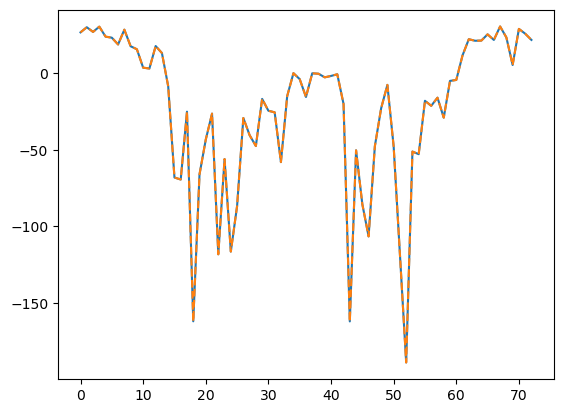

In [16]:
plt.plot(shflux[:,400,200])
plt.plot(shflux2[:,400,200],'--')

In [17]:
# mask_shelf = ma.masked_where(h > 1500, np.ones(h.shape))

shflux_mm7 = shflux.isel(ocean_time=7).where(h < 1500)

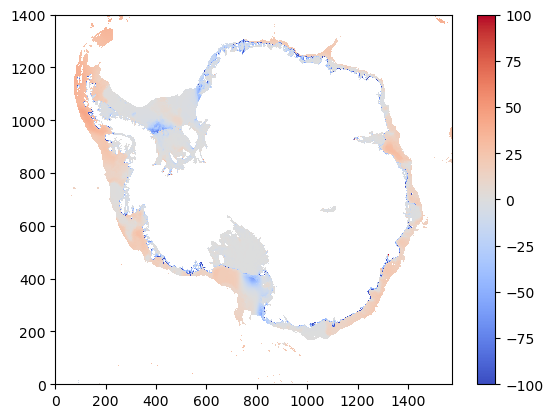

In [18]:
# plt.pcolormesh(shflux[7,:,:]*mask_shelf*mask_coast-shflux2[7,:,:]*mask_shelf*mask_coast, vmin=-100, vmax=100, cmap='coolwarm')
# plt.pcolormesh((shflux[7,:,:]*area*mask_shelf*mask_coast)-(shflux2[7,:,:]*area*mask_shelf*mask_coast), vmin=-100, vmax=100, cmap='coolwarm')
plt.pcolormesh(shflux[7,:,:].where(h < 1500), vmin=-100, vmax=100, cmap='coolwarm')
# plt.pcolormesh(shflux_mm7-(shflux2[7,:,:]*mask_shelf*mask_coast), vmin=-100, vmax=100, cmap='coolwarm')
# plt.pcolormesh(shflux[7,:,:]-(shflux2[7,:,:]*mask_shelf*mask_coast), vmin=-100, vmax=100, cmap='coolwarm')
# plt.pcolormesh(shflux[7,:,:].where(h < 1500)-(shflux2[7,:,:]*mask_shelf*mask_coast), vmin=-100, vmax=100, cmap='coolwarm')

plt.colorbar()

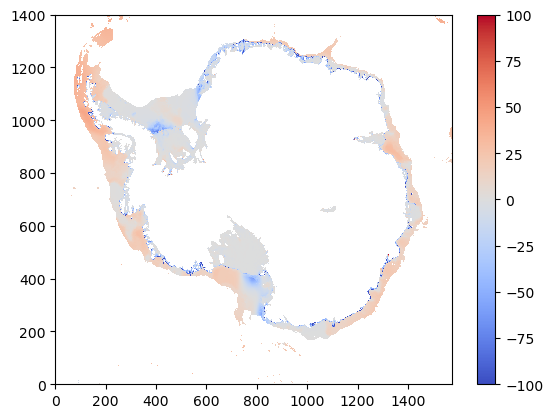

In [19]:
plt.pcolormesh(shflux2[7,:,:]*mask_shelf, vmin=-100, vmax=100, cmap='coolwarm')
plt.colorbar()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


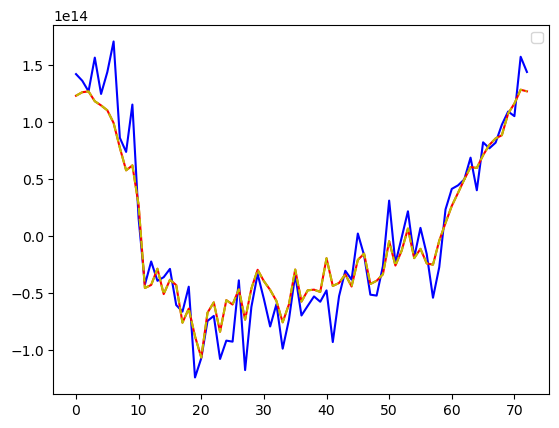

In [20]:
plt.plot(temp_rate_int-np.nanmean(temp_rate_int),'-b')
plt.plot(shflux_int-np.nanmean(shflux_int),'r')
plt.plot(shflux2_int-np.nanmean(shflux2_int),'--y')
plt.legend()


In [21]:
# OHB integrated
print(np.nanmean(temp_rate_int))#*1e-15)
print(np.nanmean(shflux_int))#*1e-15)



4585594913514.925
-67426735658131.93


Text(0.5, 0, 'Time (months)')

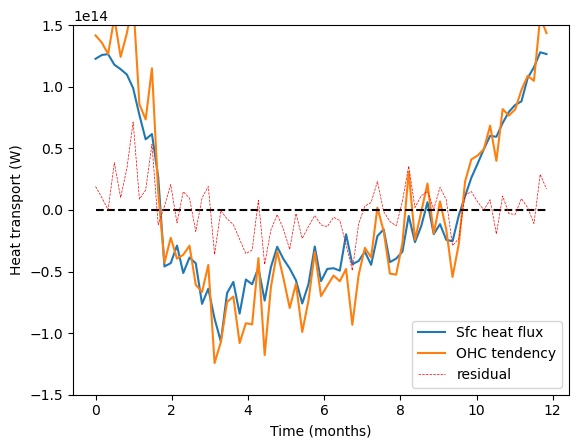

In [22]:
ohc_tend = temp_rate_int - np.nanmean(temp_rate_int)
shflux_tend = shflux_int - np.nanmean(shflux_int)

months=np.arange(0,73)*(5/30.41667)

plt.plot(months,shflux_tend, label='Sfc heat flux')
plt.plot(months,ohc_tend, label='OHC tendency')
plt.plot(months,shflux_int*0,'--k')
plt.plot(months,ohc_tend - shflux_tend, '--r', label='residual',linewidth=0.5)
plt.ylim([-1.5e14,1.5e14])

plt.legend()
plt.ylabel('Heat transport (W)')
plt.xlabel('Time (months)')
plt.title('WAOM4')